In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
root = '/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turn_cvar_posi_mul-ret-abs_noavg_21_23_min.csv'
root[:-4] + '_destop.csv'

'/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/Sep/turn_cvar_posi_mul-ret-abs_noavg_21_23_min_destop.csv'

In [3]:
cd /mnt/datadisk2/aglv/aglv/lab_aglv/

/mnt/datadisk2/aglv/aglv/lab_aglv


In [31]:
'''
因子回测系统
'''
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt

sys.path.append('/mnt/datadisk2/aglv/aglv/lab_aglv/forintern/')
from DataDaily import DataDaily

def factor_group(factor, group_number=10):
    '''按照因子值分组,grp1最小'''
    fg = factor.apply(
        lambda x: pd.qcut(x.rank(method='first'), q=group_number, labels=False) + 1, 
        axis=1)
    
    def _factor_group(factor_daily:pd.Series):
        dic = {
        f'group{str(g_value)}':factor_daily[factor_daily == g_value].index.tolist() for g_value in range(1, 1+group_number)
        }

        return pd.Series(dic)
    
    return {'group_stock':fg.apply(_factor_group, axis=1), 'group_index':fg}

def group_backtest(price:pd.DataFrame, factor:pd.DataFrame, group_number=10):
    '''
    分组回测,日度调仓,所有股票等权买入(买入各个股票的价值相同)  

    Paras:
    price:日频价格数据,index:Date,
    factor:日度因子值,index:Date,
    group_number:分组数,默认值为10, 组数大的因子值大

    Return:
    index:日期, col:组别, value: 指定日期下指定组数的收益率
    '''
    if 'Date' in factor.columns:
        factor = factor.set_index('Date')
        
    factor = factor.shift(1)
    factor = factor.drop(factor.index[0])
    
    ret = price / price.shift(1)
    ret = ret.loc[factor.index, factor.columns].fillna(1)

    fg = factor_group(factor, group_number=group_number)['group_index']
    
    dic = {}
    for g_value in tqdm(range(1, 1+group_number)):
        is_in_group = fg.applymap(lambda x: 1 if x == g_value else 0)
        group_ret_daily = (ret * is_in_group).sum(axis=1) / is_in_group.sum(axis=1)
        dic[f'group{g_value}'] = group_ret_daily

    g_ret = pd.DataFrame(dic)
    # g_ret['g_mean'] = g_ret.mean(axis=1)
    g_ret['benchmark'] = ret.mean(axis=1)

    return g_ret

def position_backtest(price:pd.DataFrame, position:pd.DataFrame):
        '''
        用仓位数据来进行回测,
        price:日度价格数据
        position:对应的日度股票持仓数量
        '''
        holding = price * position
        holding_all = holding.sum(axis=1)
        ret = holding_all / holding_all - 1

        return ret

def group_backtest_plot(price:pd.DataFrame, factor:pd.DataFrame, group_number=5, save_path=None, is_zz1000=False, gap=1):
    '''
    分组回测,日度调仓  
    Para:
    price:日频价格数据,index:Date,
    factor:日度因子值,index:Date,
    group_number:分组数,默认值为10, 组数大的因子值大
    '''

    if gap == 1:
        g_ret = group_backtest(price=price, factor=factor, group_number=group_number)
    else:
        g_ret = group_backtest_gapday(price=price, factor=factor, group_num=group_number, gap=gap) 

    g_ret.index = [str(i) for i in g_ret.index]
    g_ret_cumsum = g_ret.cumprod()

    if is_zz1000:
        index_data = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/index_data/close.csv')
        index_data.set_index('Unnamed: 0', inplace=True)
        zz1000 = index_data.loc[852, :]
        zz1000 = zz1000.loc[g_ret.index]
        zz1000_bt = zz1000 / zz1000.iloc[0]
        g_ret_cumsum['zz1000'] = zz1000_bt
    
    plt.style.use('seaborn')
    plt.figure(dpi=300)
    
    g_ret_cumsum.iloc[:, :-1].plot(figsize=(12, 6), linewidth=1)
    plt.plot(g_ret_cumsum['benchmark'], linewidth=2, label='benchmark')

    if is_zz1000:
        plt.plot(zz1000_bt, linewidth=2)

    plt.legend()

    if save_path is not None:
        plt.savefig(save_path, facecolor='white', dpi=300)
    plt.show()


def group_backtest_gapday(price:pd.DataFrame, factor:pd.DataFrame, group_num = 5, gap=10):
    '''
    换仓期为gap日的回测系统
    '''

    def handle_factor(factor, gap=gap):
        '''将因子值按gap日求平均得到新的间隔gap日的因子序列'''
        if 'Date' in factor.columns:
            factor.set_index('Date', inplace=True)
        
        new_index = [factor.index[i] for i in range(0, len(factor.index), gap)]
        new_factor = pd.DataFrame(
            [factor.loc[new_index[i]:new_index[i+1]].mean() for i in range(len(new_index) - 1)], 
            index=new_index[:-1])
        
        return new_factor
    
    new_factor = handle_factor(factor)
    new_factor = (new_factor - new_factor.mean(axis=1)) / (new_factor.std(axis = 1) + 1e-10).fillna(0)
    new_factor = new_factor.shift(1).drop(new_factor.index[0])

    price = price.loc[factor.index, factor.columns]
    ret = price / price.shift(1)
    ret = ret.fillna(1)

    fg = factor_group(factor, group_number=group_num)['group_index']
    
    dic = {}
    for g_value in tqdm(range(1, 1+group_num)):
        is_in_group = fg.applymap(lambda x: 1 if x == g_value else 0)
        group_ret_daily = (ret * is_in_group).sum(axis=1) / is_in_group.sum(axis=1)
        dic[f'group{g_value}'] = group_ret_daily

    g_ret = pd.DataFrame(dic)
    # g_ret['g_mean'] = g_ret.mean(axis=1)
    g_ret['benchmark'] = ret.mean(axis=1)

    return g_ret



def main():
    pass

if __name__ == '__main__':
    pass
    # datadaily = DataDaily()
    # close = datadaily.adjclose

    # f1 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/factor_829/inaday_cvar_neg_0.9_21_23_min.csv')
    # group_backtest_plot(close, f1)

In [18]:
def destop(factor:pd.DataFrame):
    '''
    is_trading:涨跌停股票   
    factor在第i日的因子值作为第i+1日调仓的依据, 若第i+1日涨跌停, 则第i日因子值变成NaN  
    有显著缺点  
    '''
    
    is_trading = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/is_trading.csv')
    if 'date' in is_trading.columns:
        is_trading.set_index('date', inplace=True)
    is_trading.index = [str(i) for i in is_trading.index]

    if 'Date' in factor.columns:
        factor.set_index('Date', inplace=True)
    factor.index = [str(i) for i in factor.index]

    res = factor.shift(1) * is_trading.loc[factor.index, factor.columns]
    res.index.names = ['Date']
   
    return res

In [9]:
datadaily = DataDaily()
close = datadaily.adjclose

f1 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/factor_829/inaday_cvar_neg_0.9_21_23_min.csv')


load ./data_daily.h5...


In [21]:
f2 = pd.read_csv('/mnt/datadisk2/aglv/aglv/lab_aglv/aglv_factor/factor_829/longshort_v3_vol_ret_w15_21_23_min.csv')
# f3 = destop(f2)

100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


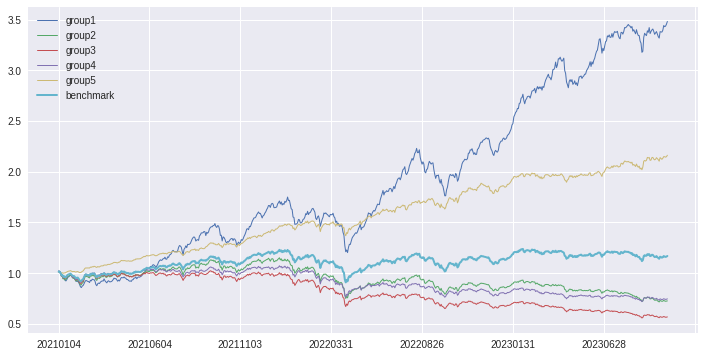

In [17]:
group_backtest_plot(close, f1, gap=20)

100%|██████████| 5/5 [00:07<00:00,  1.47s/it]


<Figure size 2400x1650 with 0 Axes>

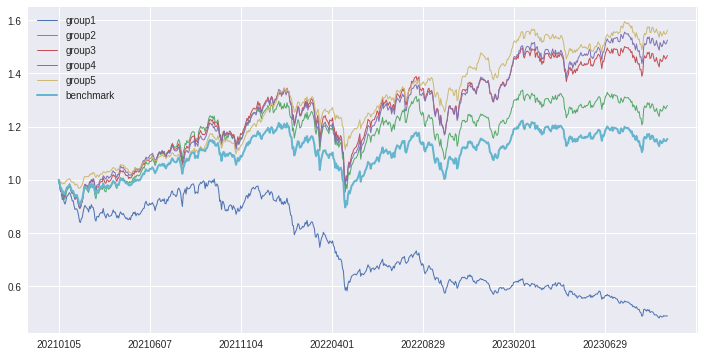

In [32]:
group_backtest_plot(close, f1)